[View in Colaboratory](https://colab.research.google.com/github/bt22dr/bt22dr.github.io/blob/master/code/sngan_fashion_mnist.ipynb)

# SNGAN fashion MNIST
*   [gan 코드](./code/gan_fashion_mnist.ipynb)를 기반으로 [sngan](https://github.com/nnUyi/SNGAN)코드를 참고하여 SNGAN를 구현함.
*   아래 [4]번 셀의 url로 Tensorboard에 접속하여 학습 과정(생성 이미지, loss) 변화를 확인할 수 있다.

In [1]:
%matplotlib inline

import os
import sys
import time

import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.contrib.eager as tfe

from tensorflow.python.layers import convolutional as tf_convolutional_layers
from tensorflow.python.layers import core as tf_core_layers

tfd = tf.contrib.distributions
layers = tf.keras.layers

tf.enable_eager_execution()

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

Found GPU at: /device:GPU:0
TensorFlow version: 1.9.0-rc2
Eager execution: True


In [2]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2018-07-09 04:27:58--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.22.213.157, 52.207.5.158, 52.22.2.149, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.22.213.157|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]   5.11M  --.-KB/s    in 0.1s    

2018-07-09 04:27:58 (43.3 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')

In [4]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://f0ec44a0.ngrok.io


In [0]:
!rm -rf checkpoints/ log/

In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

# Define the text labels
fashion_mnist_labels = ["T-shirt/top",  # index 0
                        "Trouser",      # index 1
                        "Pullover",     # index 2 
                        "Dress",        # index 3 
                        "Coat",         # index 4
                        "Sandal",       # index 5
                        "Shirt",        # index 6 
                        "Sneaker",      # index 7 
                        "Bag",          # index 8 
                        "Ankle boot"]   # index 9

4423680/4422102 [==============================] - 4s 1us/step
x_train shape: (60000, 28, 28) y_train shape: (60000,)


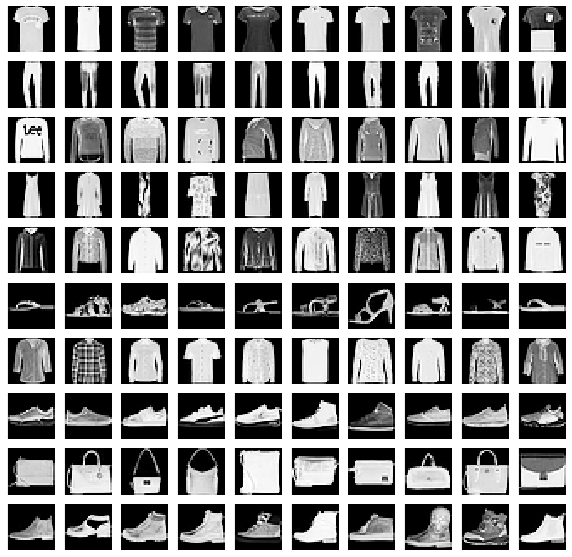

In [7]:
rows, cols = 10, 10
fig, axes = plt.subplots(figsize=(10,10), nrows=rows, ncols=cols, sharex=True, sharey=True)

for i, ax_row in enumerate(axes):
  imgs = x_test[np.where(y_test == i)[0][:10]]
  for j, ax in enumerate(ax_row):
    _ = ax.imshow(imgs[j], cmap='Greys_r')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

In [0]:
from tensorflow.python.eager import context
from tensorflow.python.framework import ops
from tensorflow.python.ops import gen_math_ops
from tensorflow.python.ops import nn
from tensorflow.python.ops import standard_ops

# Spectral Normalization GAN 구현은 
# https://github.com/nnUyi/SNGAN/blob/master/ops.py 이곳을 참조했음.

def l2_norm(input_x, epsilon=1e-12):
    input_x_norm = input_x / (tf.reduce_sum(input_x ** 2) ** 0.5 + epsilon)
    return input_x_norm
    
def weights_spectral_norm(weights, u=None):
  w_shape = weights.get_shape().as_list()
  w_mat = tf.reshape(weights, [-1, w_shape[-1]])

  if u is None:
      u = tf.get_variable(
          'u', shape=[1, w_shape[-1]], 
          initializer=tf.truncated_normal_initializer(), trainable=False)

  def power_iteration(u, ite=1):
      v_ = tf.matmul(u, tf.transpose(w_mat))
      v_hat = l2_norm(v_)
      u_ = tf.matmul(v_hat, w_mat)
      u_hat = l2_norm(u_)
      return u_hat, v_hat, ite + 1

  u_hat, v_hat, _ = power_iteration(u)
  sigma = tf.matmul(tf.matmul(v_hat, w_mat), tf.transpose(u_hat))

  w_mat = w_mat / sigma
  
  with tf.control_dependencies([u.assign(u_hat)]):
      w_norm = tf.reshape(w_mat, w_shape)
      
  return w_norm

class Conv2D_SN(tf_convolutional_layers.Conv2D, tf.keras.layers.Layer):
  def __init__(self,
               filters,
               kernel_size,
               strides=(1, 1),
               padding='valid',
               data_format=None,
               dilation_rate=(1, 1),
               activation=None,
               use_bias=True,
               kernel_initializer='glorot_uniform',
               bias_initializer='zeros',
               kernel_regularizer=None,
               bias_regularizer=None,
               activity_regularizer=None,
               kernel_constraint=None,
               bias_constraint=None,
               **kwargs):
    super(Conv2D_SN, self).__init__(
        filters,
        kernel_size,
        strides,
        padding,
        data_format,
        dilation_rate,
        activation,
        use_bias,
        kernel_initializer,
        bias_initializer,
        kernel_regularizer,
        bias_regularizer,
        activity_regularizer,
        kernel_constraint,
        bias_constraint,
        **kwargs)

  def call(self, inputs):
      weights = self.kernel
      w_norm = weights_spectral_norm(weights)
      self.kernel = w_norm

      outputs = self._convolution_op(inputs, self.kernel)

      if self.data_format == 'channels_first':
          outputs = tf.nn.bias_add(outputs, self.bias, data_format='NCHW')
      else:
          outputs = tf.nn.bias_add(outputs, self.bias, data_format='NHWC')

      if self.activation is not None:
          return self.activation(outputs)
      return outputs

class Dense_SN(tf_core_layers.Dense, tf.keras.layers.Layer):
  def __init__(self,
               units,
               activation=None,
               use_bias=True,
               kernel_initializer='glorot_uniform',
               bias_initializer='zeros',
               kernel_regularizer=None,
               bias_regularizer=None,
               activity_regularizer=None,
               kernel_constraint=None,
               bias_constraint=None,
               **kwargs):
    super(Dense_SN, self).__init__(
        units,
        activation,
        use_bias,
        kernel_initializer,
        bias_initializer,
        kernel_regularizer,
        bias_regularizer,
        activity_regularizer,
        kernel_constraint,
        bias_constraint,
        **kwargs)

  def call(self, inputs):
    weights = self.kernel
    w_norm = weights_spectral_norm(weights)
    self.kernel = w_norm
    
    inputs = ops.convert_to_tensor(inputs, dtype=self.dtype)
    shape = inputs.get_shape().as_list()
    
    if len(shape) > 2:
      # Broadcasting is required for the inputs.
      outputs = standard_ops.tensordot(inputs, self.kernel, [[len(shape) - 1],
                                                             [0]])
      # Reshape the output back to the original ndim of the input.
      if not context.executing_eagerly():
        output_shape = shape[:-1] + [self.units]
        outputs.set_shape(output_shape)
    else:
      outputs = gen_math_ops.mat_mul(inputs, self.kernel)
    if self.use_bias:
      outputs = nn.bias_add(outputs, self.bias)
    if self.activation is not None:
      return self.activation(outputs)  # pylint: disable=not-callable
    return outputs

In [0]:
class Discriminator(tf.keras.Model):
  """GAN Discriminator.
  A network to differentiate between generated and real handwritten digits.
  """

  def __init__(self, data_format):
    """Creates a model for discriminating between real and generated digits.
    Args:
      data_format: Either 'channels_first' or 'channels_last'.
        'channels_first' is typically faster on GPUs while 'channels_last' is
        typically faster on CPUs. See
        https://www.tensorflow.org/performance/performance_guide#data_formats
    """
    super(Discriminator, self).__init__(name='')
    if data_format == 'channels_first':
      self._input_shape = [-1, 1, 28, 28]
    else:
      assert data_format == 'channels_last'
      self._input_shape = [-1, 28, 28, 1]
    self.conv1 = layers.Conv2D(
        64, 5, padding='SAME', data_format=data_format, activation=None)
    self.bn1 = layers.BatchNormalization(momentum=0.8)
    self.ac1 = layers.LeakyReLU(alpha=0.2)
    self.pool1 = layers.AveragePooling2D(2, 2, data_format=data_format)
    self.conv2 = layers.Conv2D(
        128, 5, data_format=data_format, activation=None)
    self.bn2 = layers.BatchNormalization(momentum=0.8)
    self.ac2 = layers.LeakyReLU(alpha=0.2)
    self.pool2 = layers.AveragePooling2D(2, 2, data_format=data_format)
    self.flatten = layers.Flatten()
    self.fc1 = Dense_SN(1024, activation=tf.nn.leaky_relu)
    self.fc2 = Dense_SN(1, activation=None)

  def call(self, inputs):
    """Return two logits per image estimating input authenticity.
    Users should invoke __call__ to run the network, which delegates to this
    method (and not call this method directly).
    Args:
      inputs: A batch of images as a Tensor with shape [batch_size, 28, 28, 1]
        or [batch_size, 1, 28, 28]
    Returns:
      A Tensor with shape [batch_size] containing logits estimating
      the probability that corresponding digit is real.
    """
    
    x = tf.reshape(inputs, self._input_shape)
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.ac1(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.ac2(x)
    x = self.pool2(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

In [0]:
class Generator(tf.keras.Model):
  """Generator of handwritten digits similar to the ones in the MNIST dataset.
  """

  def __init__(self, data_format):
    """Creates a model for discriminating between real and generated digits.
    Args:
      data_format: Either 'channels_first' or 'channels_last'.
        'channels_first' is typically faster on GPUs while 'channels_last' is
        typically faster on CPUs. See
        https://www.tensorflow.org/performance/performance_guide#data_formats
    """
    super(Generator, self).__init__(name='')
    self.data_format = data_format
    # We are using 128 6x6 channels as input to the first deconvolution layer
    if data_format == 'channels_first':
      self._pre_conv_shape = [-1, 512, 3, 3]
    else:
      assert data_format == 'channels_last'
      self._pre_conv_shape = [-1, 3, 3, 512]
    self.fc1 = layers.Dense(3 * 3 * 512, activation=tf.nn.leaky_relu)

    # In call(), we reshape the output of fc1 to _pre_conv_shape

    # Deconvolution layer. Resulting image shape: (batch, 7, 7, 512)
    self.conv1 = layers.Conv2DTranspose(
        512, 3, strides=2, activation=None, data_format=data_format)
    self.bn1 = layers.BatchNormalization()
    self.ac1 = layers.LeakyReLU(alpha=0.2)

    # Deconvolution layer. Resulting image shape: (batch, 14, 14, 128)
    self.conv2 = layers.Conv2DTranspose(
        128, 2, strides=2, activation=None, data_format=data_format)
    self.bn2 = layers.BatchNormalization()
    self.ac2 = layers.LeakyReLU(alpha=0.2)
    
    # Deconvolution layer. Resulting image shape: (batch, 28, 28, 1)
    self.conv3 = layers.Conv2DTranspose(
        1, 2, strides=2, activation=tf.nn.sigmoid, data_format=data_format)

  def call(self, inputs):
    """Return a batch of generated images.
    Users should invoke __call__ to run the network, which delegates to this
    method (and not call this method directly).
    Args:
      inputs: A batch of noise vectors as a Tensor with shape
        [batch_size, length of noise vectors].
    Returns:
      A Tensor containing generated images. If data_format is 'channels_last',
      the shape of returned images is [batch_size, 28, 28, 1], else
      [batch_size, 1, 28, 28]
    """

    x = self.fc1(inputs)
    x = tf.reshape(x, shape=self._pre_conv_shape)
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.ac1(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.ac2(x)
    x = self.conv3(x)
    return x

In [0]:
# dummy_noise = tf.random_uniform(shape=[1,100], minval=-1., maxval=1.)
# dummy_g = Generator('channels_first')
# dummy_d = Discriminator('channels_first')
# dummy_d(dummy_g(dummy_noise))

# print(dummy_g.summary())
# print(dummy_d.summary())

In [0]:
def discriminator_loss(discriminator_real_outputs, discriminator_gen_outputs):
  """Original discriminator loss for GANs, with label smoothing.
  See `Generative Adversarial Nets` (https://arxiv.org/abs/1406.2661) for more
  details.
  Args:
    discriminator_real_outputs: Discriminator output on real data.
    discriminator_gen_outputs: Discriminator output on generated data. Expected
      to be in the range of (-inf, inf).
  Returns:
    A scalar loss Tensor.
  """

  loss_on_real = tf.losses.sigmoid_cross_entropy(
      tf.ones_like(discriminator_real_outputs),
      discriminator_real_outputs,
      label_smoothing=0.1)
  loss_on_generated = tf.losses.sigmoid_cross_entropy(
      tf.zeros_like(discriminator_gen_outputs), discriminator_gen_outputs)
  loss = loss_on_real + loss_on_generated
  tf.contrib.summary.scalar('discriminator_loss', loss)
  return loss


def generator_loss(discriminator_gen_outputs):
  """Original generator loss for GANs.
  L = -log(sigmoid(D(G(z))))
  See `Generative Adversarial Nets` (https://arxiv.org/abs/1406.2661)
  for more details.
  Args:
    discriminator_gen_outputs: Discriminator output on generated data. Expected
      to be in the range of (-inf, inf).
  Returns:
    A scalar loss Tensor.
  """
  loss = tf.losses.sigmoid_cross_entropy(
      tf.ones_like(discriminator_gen_outputs), discriminator_gen_outputs)
  tf.contrib.summary.scalar('generator_loss', loss)
  return loss

In [0]:
def train_one_epoch(generator, discriminator, generator_optimizer,
                    discriminator_optimizer, dataset, step_counter,
                    log_interval, noise_dim):
  """Trains `generator` and `discriminator` models on `dataset`.
  Args:
    generator: Generator model.
    discriminator: Discriminator model.
    generator_optimizer: Optimizer to use for generator.
    discriminator_optimizer: Optimizer to use for discriminator.
    dataset: Dataset of images to train on.
    step_counter: An integer variable, used to write summaries regularly.
    log_interval: How many steps to wait between logging and collecting
      summaries.
    noise_dim: Dimension of noise vector to use.
  """

  total_generator_loss = 0.0
  total_discriminator_loss = 0.0
  for (batch_index, images) in enumerate(tfe.Iterator(dataset)):
    with tf.device('/cpu:0'):
      tf.assign_add(step_counter, 1)

    with tf.contrib.summary.record_summaries_every_n_global_steps(
        log_interval, global_step=step_counter):
      current_batch_size = images.shape[0]
      noise = tf.random_uniform(
          shape=[current_batch_size, noise_dim],
          minval=-1.,
          maxval=1.,
          seed=batch_index)

      with tf.GradientTape(persistent=True) as g:
        generated_images = generator(noise)
        tf.contrib.summary.image(
            'generated_images',
            tf.reshape(generated_images, [-1, 28, 28, 1]),
            max_images=10)

        discriminator_gen_outputs = discriminator(generated_images)
        discriminator_real_outputs = discriminator(images)
        discriminator_loss_val = discriminator_loss(discriminator_real_outputs,
                                                    discriminator_gen_outputs)
        total_discriminator_loss += discriminator_loss_val

        generator_loss_val = generator_loss(discriminator_gen_outputs)
        total_generator_loss += generator_loss_val

      generator_grad = g.gradient(generator_loss_val, generator.variables)
      discriminator_grad = g.gradient(discriminator_loss_val,
                                      discriminator.variables)

      generator_optimizer.apply_gradients(
          zip(generator_grad, generator.variables))
      discriminator_optimizer.apply_gradients(
          zip(discriminator_grad, discriminator.variables))

      if log_interval and batch_index > 0 and batch_index % log_interval == 0:
        print('Batch #%d\tAverage Generator Loss: %.6f\t'
              'Average Discriminator Loss: %.6f' %
              (batch_index, total_generator_loss / batch_index,
               total_discriminator_loss / batch_index))

In [0]:
import argparse

parser = argparse.ArgumentParser()
parser.add_argument(
    '--data-dir',
    type=str,
    default='/tmp/tensorflow/mnist/input_data',
    help=('Directory for storing input data (default '
          '/tmp/tensorflow/mnist/input_data)'))
parser.add_argument(
    '--batch-size',
    type=int,
    default=128,
    metavar='N',
    help='input batch size for training (default: 128)')
parser.add_argument(
    '--log-interval',
    type=int,
    default=100,
    metavar='N',
    help=('number of batches between logging and writing summaries '
          '(default: 100)'))
parser.add_argument(
    '--output_dir',
    type=str,
    default='log',
    metavar='DIR',
    help='Directory to write TensorBoard summaries (defaults to none)')
parser.add_argument(
    '--checkpoint_dir',
    type=str,
    default='./checkpoints/',
    metavar='DIR',
    help=('Directory to save checkpoints in (once per epoch) (default '
          '/tmp/tensorflow/mnist/checkpoints/)'))
parser.add_argument(
    '--lr',
    type=float,
    default=0.0001,
    metavar='LR',
    help='learning rate (default: 0.0001)')
parser.add_argument(
    '--noise',
    type=int,
    default=100,
    metavar='N',
    help='Length of noise vector for generator input (default: 100)')
parser.add_argument(
    '--no-gpu',
    action='store_true',
    default=False,
    help='disables GPU usage even if a GPU is available')

FLAGS, unparsed = parser.parse_known_args()

In [15]:
(device, data_format) = ('/gpu:0', 'channels_first')
if FLAGS.no_gpu or tfe.num_gpus() <= 0:
  (device, data_format) = ('/cpu:0', 'channels_last')
print('Using device %s, and data format %s.' % (device, data_format))

# Load the datasets
dataset = (
    tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000) # TODO: keras ImageDataGenerator 사용
    .batch(FLAGS.batch_size))

# Create the models and optimizers.
model_objects = {
    'generator': Generator(data_format),
    'discriminator': Discriminator(data_format),
    'generator_optimizer': tf.train.AdamOptimizer(FLAGS.lr),
    'discriminator_optimizer': tf.train.AdamOptimizer(FLAGS.lr),
    'step_counter': tf.train.get_or_create_global_step(),
}

# Prepare summary writer and checkpoint info
summary_writer = tf.contrib.summary.create_summary_file_writer(
    FLAGS.output_dir, flush_millis=1000)
checkpoint_prefix = os.path.join(FLAGS.checkpoint_dir, 'ckpt')
latest_cpkt = tf.train.latest_checkpoint(FLAGS.checkpoint_dir)
if latest_cpkt:
  print('Using latest checkpoint at ' + latest_cpkt)
checkpoint = tfe.Checkpoint(**model_objects)
# Restore variables on creation if a checkpoint exists.
checkpoint.restore(latest_cpkt)

with tf.device(device):
  for _ in range(100):
    start = time.time()
    with summary_writer.as_default():
      train_one_epoch(dataset=dataset, log_interval=FLAGS.log_interval,
                      noise_dim=FLAGS.noise, **model_objects)
    end = time.time()
    checkpoint.save(checkpoint_prefix)
    print('\nTrain time for epoch #%d (step %d): %f' %
          (checkpoint.save_counter.numpy(),
           checkpoint.step_counter.numpy(),
           end - start))

Using device /gpu:0, and data format channels_first.
Batch #100	Average Generator Loss: 0.806193	Average Discriminator Loss: 1.165865
Batch #200	Average Generator Loss: 0.881926	Average Discriminator Loss: 1.007154
Batch #300	Average Generator Loss: 0.922602	Average Discriminator Loss: 1.099890
Batch #400	Average Generator Loss: 1.023462	Average Discriminator Loss: 1.080363

Train time for epoch #1 (step 469): 83.762429
Batch #100	Average Generator Loss: 1.352918	Average Discriminator Loss: 0.991719
Batch #200	Average Generator Loss: 1.346401	Average Discriminator Loss: 1.043390
Batch #300	Average Generator Loss: 1.201953	Average Discriminator Loss: 1.034755
Batch #400	Average Generator Loss: 1.174204	Average Discriminator Loss: 1.051920

Train time for epoch #2 (step 938): 81.929237
Batch #100	Average Generator Loss: 0.913327	Average Discriminator Loss: 1.312157
Batch #200	Average Generator Loss: 0.894963	Average Discriminator Loss: 1.251004
Batch #300	Average Generator Loss: 0.871596


Train time for epoch #10 (step 4690): 82.486183
Batch #100	Average Generator Loss: 0.897009	Average Discriminator Loss: 1.221771
Batch #200	Average Generator Loss: 0.918866	Average Discriminator Loss: 1.231202
Batch #300	Average Generator Loss: 0.894127	Average Discriminator Loss: 1.235397
Batch #400	Average Generator Loss: 0.901321	Average Discriminator Loss: 1.237169

Train time for epoch #11 (step 5159): 82.575121
Batch #100	Average Generator Loss: 0.875932	Average Discriminator Loss: 1.255497
Batch #200	Average Generator Loss: 0.873612	Average Discriminator Loss: 1.265394
Batch #300	Average Generator Loss: 0.871089	Average Discriminator Loss: 1.271079
Batch #400	Average Generator Loss: 0.868577	Average Discriminator Loss: 1.273500

Train time for epoch #12 (step 5628): 82.494919
Batch #100	Average Generator Loss: 0.866519	Average Discriminator Loss: 1.292577
Batch #200	Average Generator Loss: 0.875038	Average Discriminator Loss: 1.294516
Batch #300	Average Generator Loss: 0.866903

Batch #100	Average Generator Loss: 0.766562	Average Discriminator Loss: 1.405372
Batch #200	Average Generator Loss: 0.769481	Average Discriminator Loss: 1.386756
Batch #300	Average Generator Loss: 0.768550	Average Discriminator Loss: 1.383617
Batch #400	Average Generator Loss: 0.767693	Average Discriminator Loss: 1.382540

Train time for epoch #21 (step 9849): 82.033802
Batch #100	Average Generator Loss: 0.786158	Average Discriminator Loss: 1.383441
Batch #200	Average Generator Loss: 0.770681	Average Discriminator Loss: 1.380446
Batch #300	Average Generator Loss: 0.775509	Average Discriminator Loss: 1.374699
Batch #400	Average Generator Loss: 0.774642	Average Discriminator Loss: 1.373385

Train time for epoch #22 (step 10318): 82.023303
Batch #100	Average Generator Loss: 0.815692	Average Discriminator Loss: 1.376234
Batch #200	Average Generator Loss: 0.794234	Average Discriminator Loss: 1.370351
Batch #300	Average Generator Loss: 0.784206	Average Discriminator Loss: 1.371303
Batch #400

Batch #200	Average Generator Loss: 0.765024	Average Discriminator Loss: 1.376951
Batch #300	Average Generator Loss: 0.774444	Average Discriminator Loss: 1.373323
Batch #400	Average Generator Loss: 0.775381	Average Discriminator Loss: 1.371489

Train time for epoch #31 (step 14539): 82.098587
Batch #100	Average Generator Loss: 0.786308	Average Discriminator Loss: 1.366217
Batch #200	Average Generator Loss: 0.777878	Average Discriminator Loss: 1.365242
Batch #300	Average Generator Loss: 0.779104	Average Discriminator Loss: 1.367897
Batch #400	Average Generator Loss: 0.779143	Average Discriminator Loss: 1.366151

Train time for epoch #32 (step 15008): 82.022187
Batch #100	Average Generator Loss: 0.765379	Average Discriminator Loss: 1.392846
Batch #200	Average Generator Loss: 0.775070	Average Discriminator Loss: 1.381480
Batch #300	Average Generator Loss: 0.775064	Average Discriminator Loss: 1.375194
Batch #400	Average Generator Loss: 0.771854	Average Discriminator Loss: 1.369945

Train ti

Batch #300	Average Generator Loss: 0.767264	Average Discriminator Loss: 1.373870
Batch #400	Average Generator Loss: 0.768731	Average Discriminator Loss: 1.372176

Train time for epoch #41 (step 19229): 81.965497
Batch #100	Average Generator Loss: 0.760593	Average Discriminator Loss: 1.385838
Batch #200	Average Generator Loss: 0.762267	Average Discriminator Loss: 1.376829
Batch #300	Average Generator Loss: 0.760670	Average Discriminator Loss: 1.373683
Batch #400	Average Generator Loss: 0.763332	Average Discriminator Loss: 1.372966

Train time for epoch #42 (step 19698): 81.936946
Batch #100	Average Generator Loss: 0.770419	Average Discriminator Loss: 1.383952
Batch #200	Average Generator Loss: 0.769513	Average Discriminator Loss: 1.377316
Batch #300	Average Generator Loss: 0.767801	Average Discriminator Loss: 1.373575
Batch #400	Average Generator Loss: 0.768433	Average Discriminator Loss: 1.369698

Train time for epoch #43 (step 20167): 81.501634
Batch #100	Average Generator Loss: 0.774

Batch #400	Average Generator Loss: 0.774875	Average Discriminator Loss: 1.373532

Train time for epoch #51 (step 23919): 82.170805
Batch #100	Average Generator Loss: 0.766864	Average Discriminator Loss: 1.390009
Batch #200	Average Generator Loss: 0.769791	Average Discriminator Loss: 1.378760
Batch #300	Average Generator Loss: 0.762891	Average Discriminator Loss: 1.377479
Batch #400	Average Generator Loss: 0.762811	Average Discriminator Loss: 1.376202

Train time for epoch #52 (step 24388): 82.180422
Batch #100	Average Generator Loss: 0.765207	Average Discriminator Loss: 1.386213
Batch #200	Average Generator Loss: 0.765378	Average Discriminator Loss: 1.377890
Batch #300	Average Generator Loss: 0.763983	Average Discriminator Loss: 1.375810
Batch #400	Average Generator Loss: 0.761125	Average Discriminator Loss: 1.375348

Train time for epoch #53 (step 24857): 82.217980
Batch #100	Average Generator Loss: 0.760276	Average Discriminator Loss: 1.389673
Batch #200	Average Generator Loss: 0.761


Train time for epoch #61 (step 28609): 82.118820
Batch #100	Average Generator Loss: 0.788728	Average Discriminator Loss: 1.388735
Batch #200	Average Generator Loss: 0.771104	Average Discriminator Loss: 1.380527
Batch #300	Average Generator Loss: 0.769312	Average Discriminator Loss: 1.375567
Batch #400	Average Generator Loss: 0.767793	Average Discriminator Loss: 1.375284

Train time for epoch #62 (step 29078): 82.170008
Batch #100	Average Generator Loss: 0.767379	Average Discriminator Loss: 1.380979
Batch #200	Average Generator Loss: 0.765281	Average Discriminator Loss: 1.378594
Batch #300	Average Generator Loss: 0.767669	Average Discriminator Loss: 1.377047
Batch #400	Average Generator Loss: 0.772664	Average Discriminator Loss: 1.375070

Train time for epoch #63 (step 29547): 82.217182
Batch #100	Average Generator Loss: 0.769952	Average Discriminator Loss: 1.386958
Batch #200	Average Generator Loss: 0.769926	Average Discriminator Loss: 1.378876
Batch #300	Average Generator Loss: 0.768

Batch #100	Average Generator Loss: 0.749940	Average Discriminator Loss: 1.389959
Batch #200	Average Generator Loss: 0.759716	Average Discriminator Loss: 1.379142
Batch #300	Average Generator Loss: 0.760246	Average Discriminator Loss: 1.377328
Batch #400	Average Generator Loss: 0.760182	Average Discriminator Loss: 1.374064

Train time for epoch #72 (step 33768): 81.930786
Batch #100	Average Generator Loss: 0.769148	Average Discriminator Loss: 1.381933
Batch #200	Average Generator Loss: 0.763805	Average Discriminator Loss: 1.378098
Batch #300	Average Generator Loss: 0.762110	Average Discriminator Loss: 1.375641
Batch #400	Average Generator Loss: 0.760174	Average Discriminator Loss: 1.375644

Train time for epoch #73 (step 34237): 82.127706
Batch #100	Average Generator Loss: 0.767154	Average Discriminator Loss: 1.380334
Batch #200	Average Generator Loss: 0.759726	Average Discriminator Loss: 1.379432
Batch #300	Average Generator Loss: 0.760532	Average Discriminator Loss: 1.376031
Batch #40

Batch #200	Average Generator Loss: 0.777618	Average Discriminator Loss: 1.372126
Batch #300	Average Generator Loss: 0.774198	Average Discriminator Loss: 1.369806
Batch #400	Average Generator Loss: 0.768070	Average Discriminator Loss: 1.369636

Train time for epoch #82 (step 38458): 82.163846
Batch #100	Average Generator Loss: 0.768088	Average Discriminator Loss: 1.383670
Batch #200	Average Generator Loss: 0.759869	Average Discriminator Loss: 1.378110
Batch #300	Average Generator Loss: 0.761752	Average Discriminator Loss: 1.376805
Batch #400	Average Generator Loss: 0.759059	Average Discriminator Loss: 1.375597

Train time for epoch #83 (step 38927): 82.205563
Batch #100	Average Generator Loss: 0.761573	Average Discriminator Loss: 1.390337
Batch #200	Average Generator Loss: 0.761997	Average Discriminator Loss: 1.378676
Batch #300	Average Generator Loss: 0.759395	Average Discriminator Loss: 1.380166
Batch #400	Average Generator Loss: 0.759172	Average Discriminator Loss: 1.378040

Train ti

Batch #300	Average Generator Loss: 0.762312	Average Discriminator Loss: 1.379443
Batch #400	Average Generator Loss: 0.760729	Average Discriminator Loss: 1.377018

Train time for epoch #92 (step 43148): 82.256490
Batch #100	Average Generator Loss: 0.767509	Average Discriminator Loss: 1.387126
Batch #200	Average Generator Loss: 0.764694	Average Discriminator Loss: 1.380752
Batch #300	Average Generator Loss: 0.764184	Average Discriminator Loss: 1.378369
Batch #400	Average Generator Loss: 0.762069	Average Discriminator Loss: 1.377323

Train time for epoch #93 (step 43617): 82.147297
Batch #100	Average Generator Loss: 0.771533	Average Discriminator Loss: 1.379268
Batch #200	Average Generator Loss: 0.765045	Average Discriminator Loss: 1.376131
Batch #300	Average Generator Loss: 0.762455	Average Discriminator Loss: 1.377865
Batch #400	Average Generator Loss: 0.761079	Average Discriminator Loss: 1.377348

Train time for epoch #94 (step 44086): 82.146341
Batch #100	Average Generator Loss: 0.768

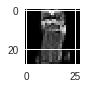

In [16]:
noise = np.random.random((1, FLAGS.noise))*2-1
generated_images = model_objects["generator"](noise)
generated_image = np.squeeze(generated_images.numpy())
plt.figure(figsize=(1,1))
plt.imshow(generated_image, cmap='gray')

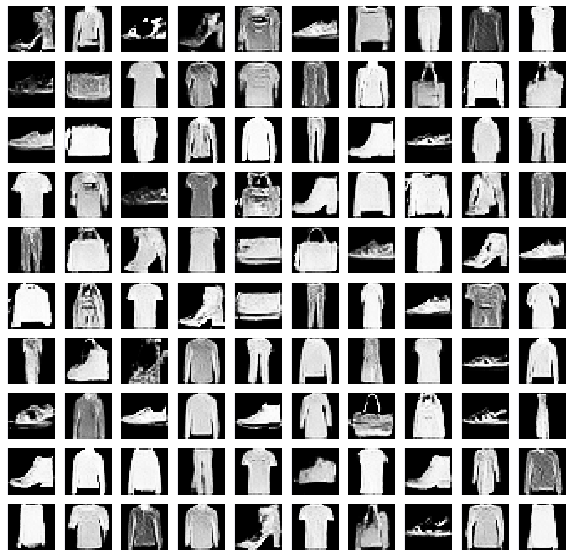

In [17]:
rows, cols = 10, 10
fig, axes = plt.subplots(figsize=(10,10), nrows=rows, ncols=cols, sharex=True, sharey=True)

noise = np.random.random((100, FLAGS.noise))*2-1
generated_images = model_objects["generator"](noise)
generated_images = np.squeeze(generated_images.numpy())

for i, ax_row in enumerate(axes):
  for j, ax in enumerate(ax_row):
    _ = ax.imshow(generated_images[i*10+j], cmap='Greys_r')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)